In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sqlite3
import country_converter as coco

In [2]:
df = pd.read_excel("Data Science Job Salaries.xlsx")
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

work_year experience_level employment_type                   job_title  \
0       2020               MI              FT              Data Scientist   
1       2020               SE              FT  Machine Learning Scientist   
2       2020               SE              FT           Big Data Engineer   
3       2020               MI              FT        Product Data Analyst   
4       2020               SE              FT   Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   70000             EUR          79833                 DE             0   
1  260000             USD         260000                 JP             0   
2   85000             GBP         109024                 GB            50   
3   20000             USD          20000                 HN             0   
4  150000             USD         150000                 US            50   

  company_location company_size  
0               DE            L  
1               JP            S  
2               GB            M  
3               HN            S  
4               US            L

In [3]:
df.drop_duplicates(inplace=True)

df.drop(columns=['salary'], inplace=True)

df.rename(columns={
    'salary_in_usd': 'salary',
    'remote_ratio': 'job_type'
}, inplace=True)

df['experience_level'] = df['experience_level'].map({
    'EN': 'Entry', 'MI': 'Mid', 'SE': 'Senior', 'EX': 'Executive'
})

df['employment_type'] = df['employment_type'].map({
    'FT': 'Full-time', 'PT': 'Part-time', 'CT': 'Contract', 'FL': 'Freelance'
})

df['company_size'] = df['company_size'].map({
    'S': 'Small', 'M': 'Medium', 'L': 'Large'
})

df['job_type'] = df['job_type'].map({
    0: 'Onsite', 50: 'Hybrid', 100: 'Remote'
})

cc = coco.CountryConverter()
df['company_location'] = cc.convert(names=df['company_location'], to='name_short')
df['employee_residence'] = cc.convert(names=df['employee_residence'], to='name_short')

df.drop(columns=['salary_currency'], inplace=True)

df.head()

work_year experience_level employment_type                   job_title  \
0       2020              Mid       Full-time              Data Scientist   
1       2020           Senior       Full-time  Machine Learning Scientist   
2       2020           Senior       Full-time           Big Data Engineer   
3       2020              Mid       Full-time        Product Data Analyst   
4       2020           Senior       Full-time   Machine Learning Engineer   

   salary employee_residence job_type company_location company_size  
0   79833            Germany   Onsite          Germany        Large  
1  260000              Japan   Onsite            Japan        Small  
2  109024     United Kingdom   Hybrid   United Kingdom       Medium  
3   20000           Honduras   Onsite         Honduras        Small  
4  150000      United States   Hybrid    United States        Large

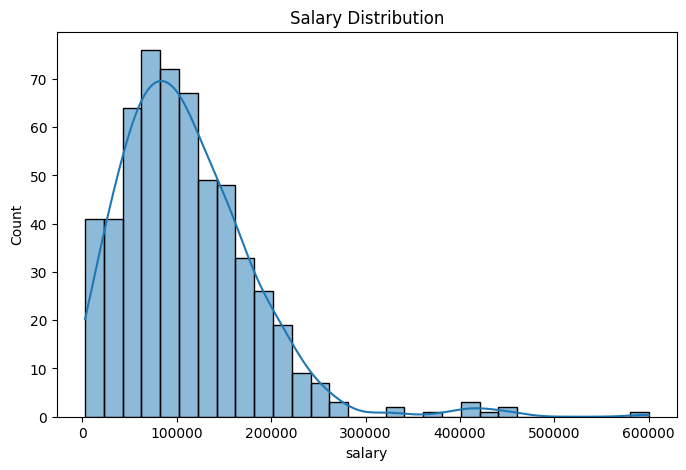

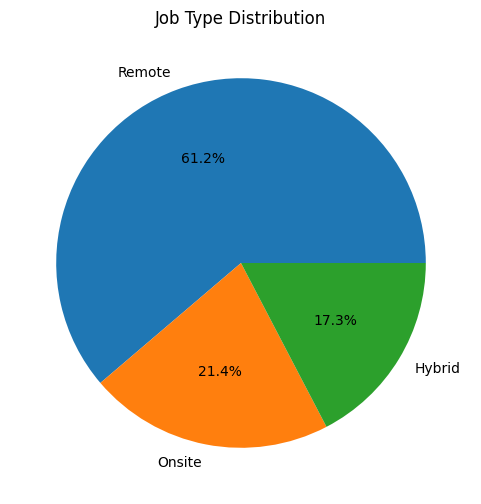

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df['salary'], bins=30, kde=True)
plt.title("Salary Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='experience_level', y='salary', data=df)
plt.title("Salary by Experience Level")
plt.show()

df['job_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Job Type Distribution")
plt.ylabel("")
plt.show()

In [5]:
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop('salary', axis=1)
y = df_encoded['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:", mean_squared_error(y_test,y_pred))

Mean Absolute Error: 37607.134685357836
Mean Squared Error: 3728790708.522823


In [6]:
conn = sqlite3.connect("salaries.db")
df.to_sql("salaries", conn, if_exists="replace", index=False)

query = """
SELECT job_title, ROUND(AVG(salary), 2) as avg_salary
FROM salaries
GROUP BY job_title
ORDER BY avg_salary DESC
LIMIT 5;
"""
result = conn.execute(query).fetchall()
for row in result:
    print(f"{row[0]} → ${row[1]}")

Data Analytics Lead → $405000.0
Principal Data Engineer → $328333.33
Financial Data Analyst → $275000.0
Principal Data Scientist → $215242.43
Director of Data Science → $195074.0
